# Segmentation into ERP epochs

In this lesson we will learn how to segment continuous EEG data into epochs, time-locked to experimental events of interest. This is the stage at which we move from working with EEG data, to ERP data. Recall that *ERP* stands for *event-related potential* — short segments of EEG data that are time-locked to particular events such as stimulus onsets or participant responses. In the previous steps we removed artifacts from the continuous EEG data. Now, we will segment the data into epochs, and apply artifact correction to the segments, based on the ICA decomposition that we performed in the previous step, as well as using the AutoReject algorithm to automatically detect and remove bad epochs and channels that ICA may not fix.

## Import MNE and Read Filtered Data

We will segment the band-pass filtered version of the continuous EEG data that we created in the filtering lesson

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np

# Participant ID code
p_id = 'sub-001'
data_dir = 'data/' + p_id + '/'

raw_filt = mne.io.read_raw_fif(data_dir + p_id + '-filt-raw.fif')

### MNE's events structure

**Event codes** indicate when events of experimental interest occurred during the EEG recording. They are typically generated by the stimulus computer, and sent to the EEG recording computer at the same time that the stimuli are presented to the participant. Event codes may also mark when a participant made a response (such as a button press, or the onset of a vocal response), or other information such as the start of a new bock of trials or condition, rather than a specific stimulus. 


Segmenting the data into ERPs depends on these event codes, since they are what we time-lock to. To use them for ERP segmentation, we need to first extract the timing and identity of each code from the raw data, and store it in a NumPy array. Because event codes are numeric (for reasons explained below), we also need to define a mapping between these numbers and meaningful labels (such as what type of stimulus or experimental condition the code denotes). 

We use `mne.events_from_annotations()` to extract the event codes from the raw data and store them in a NumPy array called `events`. The function actually produces two outputs; the second is a dictionary mapping the event codes to labels, which we assign to `events_dict`:

In [2]:
events, events_dict = mne.events_from_annotations(raw_filt)

We can view the first 10 rows of the `events` array:

In [3]:
events[:10]

array([[    0,     0,     2],
       [    0,     0,     1],
       [25550,     0,     7],
       [25553,     0,     3],
       [26099,     0,    13],
       [26144,     0,     4],
       [29582,     0,     5],
       [33283,     0,     3],
       [33781,     0,    15],
       [34932,     0,     5]])

`events` is a NumPy array with 3 columns, and one row for each event code in the data. 

The **first column** contains the index of the event code in terms of the data array. Recall that the data were sampled at a rate of 500 Hz, meaning we have one sample (i.e., measurement) every 2 ms. So the values in the first column of `events` are not time measured in milliseconds, but "time" in terms of samples or data points. This is important to remember later, although MNE generally makes it easy to go between samples and more intuitive measures of time like milliseconds or seconds.

The **second column** is usually zero, but is intended to mark the end time off an event, if the event code was send to the EEG system for a period of time. In practice it is rarely used, and we will ignore it.

The **third column** is the event code itself, as an integer. We'll elaborate later on what each code means.


### About Event Codes

Most EEG systems receive event codes from the stimulus computer using an electronic communications protocol called **TTL**, or transistor-to-transistor logic. It's very simple and low-level, and is done via the parallel port of a computer (which is so low-level, computers almost never have these built in anymore). The reason this arcane system is still routinely used in EEG is that its timing is very precise, which means it is the best option to get millisecond-level synchronization between when the stimulus computer presents a stimulus, and when the event code is received by the EEG system. This level of precision is vital in EEG research because the effects of interest occur on a millisecond time scale. The impact of this system for us is that the event codes stored in an EEG data file are usually restricted to integers in the range of 1–255, because that is the (8 bit) resolution of the TTL protocol (i.e., this kind of connection can inherently only send this range of values). Some EEG recording software allows the experimenter to specify text labels for each numerical event code, based on what the numbers mean in that particular experiment. However, in most cases mapping between the numerical event codes and meaningful labels is something we do in preprocessing, as shown below.

:::{note}

A modern replacement for TTL signals is the [**Lab Streaming Layer**](https://labstreaminglayer.org/) (LSL), which is a software-based system for sending event codes and other data between computers. LSL involves one computer running an LSL server application, which other computers (or processes on the same computer) send data to via a network connection. LSL has a sophisticated way of synchronizing timing between multiple computers, which allows for good temporal precision. Besides not requiring computers that have parallel ports, LSL can aggregate data streams from a variety of sources, including stimulus presentation software, EEG and fNIRS systems, eye trackers, motion capture systems, and more. In the present data sets we use TTL codes, however MNE supports LSL and the processes demonstrated here are similar for LSL data.


### The Event Dictionary 

When MNE reads the event codes from a raw data file, it does a step that isn't always intuitive. Event codes in raw data files can take a variety of forms, depending on the software that was used to record the data. MNE searches through the raw data, and finds each unique event code (keeping in mind that event codes typically indicate a category of stimuli, or experimental condition, not the identity of individual stimuli or trials). MNE treats the event codes as strings, even if they are all numeric. MNE then assigns each unique event code an integer value. This mapping between original event codes and integers is stored in a dictionary called `events_dict`:

In [4]:
events_dict

{'Comment/actiCAP Data On': 1,
 'New Segment/': 2,
 'Stimulus/S  1': 3,
 'Stimulus/S  2': 4,
 'Stimulus/S  3': 5,
 'Stimulus/S  4': 6,
 'Stimulus/S  5': 7,
 'Stimulus/S  7': 8,
 'Stimulus/S101': 9,
 'Stimulus/S102': 10,
 'Stimulus/S111': 11,
 'Stimulus/S112': 12,
 'Stimulus/S201': 13,
 'Stimulus/S202': 14,
 'Stimulus/S211': 15,
 'Stimulus/S212': 16}

In the above dictionary, the original event codes are the dictionary keys (on the left of the colons). You can see that the first two entries are not of experimental interest, but simply note the start of recording. The other event codes were originally numeric, but the recording software pre-pended `Stimulus/S` to the start of each one. MNE has simply matched each one to an integer, so the event codes used in MNE don't match the original event codes. This is why `events_dict` is critical to ensuring that you map the right event codes to the each event of experimental interest. Another step is required, though, because we need a way of mapping from the the codes that MNE is using in the data, to the labels for the events that make sense to us in terms of the experiment (e.g., different stimulus types, response onsets, etc.). 

### How MNE Interprets Event Codes

There is actually a workaround for this. In the present case, we imported the filtered data that we created in a previous lesson. If instead we had applied `mne.events_from_annotations()` to the original `raw` data file, MNE would be able to parse the event codes, and will assign them the same integer values that they had in the original data file. This is because the original data file was in the BrainVision format, which stores the event codes in a way that MNE can read. However, if you apply `mne.events_from_annotations()` to the `raw_filt` data file, MNE will not be able to parse the event codes, because the data file is in the `.fif` format, which stores the event codes differently. In this case, MNE will assign new integer values to the event codes, starting at 1 for the first event code it finds in the file, as we see here. 

For reference, let's see the difference when we read the original raw file. Since we only want the event codes, and not the data,  we can speed the process up by setting the kwarg `preload=False`. This tells MNE to read the metadata from the file, but not the data itself. This also saves memory.

In [5]:
raw = mne.io.read_raw_brainvision(data_dir + p_id + '.vhdr', preload=False)
events_raw, events_dict_raw = mne.events_from_annotations(raw)
events_dict_raw

{'Comment/actiCAP Data On': 10001,
 'New Segment/': 99999,
 'Stimulus/S  1': 1,
 'Stimulus/S  2': 2,
 'Stimulus/S  3': 3,
 'Stimulus/S  4': 4,
 'Stimulus/S  5': 5,
 'Stimulus/S  7': 7,
 'Stimulus/S101': 101,
 'Stimulus/S102': 102,
 'Stimulus/S111': 111,
 'Stimulus/S112': 112,
 'Stimulus/S201': 201,
 'Stimulus/S202': 202,
 'Stimulus/S211': 211,
 'Stimulus/S212': 212}

In practice it would make sense to read in the original raw file here to get the event codes. However, we will continue with the filtered data, because it provides an opportunity to demonstrate how to re-map information between two Python dictionaries, which is a useful thing to learn about.


## Label Event Codes – Mapping Between Dictionaries


:::{admonition} Background on the Experiment that Generated These Data

This data set was collected while the participant viewed a series of pictures of objects on a computer screen. One second after each picture was presented, a spoken word was played over a speaker. The word was either the name of the pictured object, or some other word. Based on prior research, we predicted an **N400** ERP component for the mismatch trials relative to those on which the picture and word matched. In other words, the experimental contrast we are interested in is between **Match** and **Mismatch** trials.

The N400 is a component first discovered by [Kutas & Hillyard (1980)](https://dx.doi.org/10.1126/science.7350657), in response to sentences that ended in a word whose meaning was not predicted given the preceding words in the sentence. For example, the sentence *I take my coffee with milk and dog.* would elicit an N400 at the word *dog*. More than 40 years of subsequent research has shown that the N400 is a marker of brain processes involved in integrating new information into an ongoing context that people maintain of words and concepts — or in technical terms, *semantic integration*. Violations of expectations related to the meaning of stimuli evoke an N400 response. In the present experiment, we did not use sentences, however each picture created a context and the subsequent word either fit (matched) or did not fit (mismatched) that context. 

Although there were really only two experimental conditions in this experiment (match and mismatch), as you  there are a lot more than two event codes in the `events` array and `events_dict` dictionary above! This is because in this study, the experimenters coded details of the stimuli in great detail. This is common in research, where we have one central research question, but perhaps other questions relating to more fine-grained details of the stimuli. As well, the stimuli may vary in ways that are not of experimental interest, but are properties that we would like to control for. For now we will label each event code.


We can define a dictionary that maps labels onto each (original) event code of interest:

In [6]:
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5, 'unused':7,          
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }

We now need to map between `events_dict` and `event_mapping`. The first thing we'll do is swap the keys and values in `event_mapping`, because once we extract the original, numerical event codes from `events_dict` we will want to use them as keys to index into `event_mapping` so that we can find the corresponding labels. We can do this with a dictionary comprehension (which is like list comprehension, but for dictionaries). `event_mapping.items()` will generate two outputs: the keys and the values of the dictionary. We can then swap them by putting the values first, and the keys second, separated by a colon. We then wrap this in curly braces to indicate that we are creating a dictionary:

In [7]:
# swap keys and values in event_mapping
event_mapping = {v:k for k,v in event_mapping.items()}
event_mapping

{1: 'PicOnset',
 2: 'RespPrompt',
 3: 'CorResp',
 4: 'IncorResp',
 5: 'RespFeedback',
 7: 'unused',
 111: 'Match/A',
 211: 'Match/B',
 112: 'Match/C',
 212: 'Match/D',
 101: 'Mismatch/A',
 201: 'Mismatch/B',
 102: 'Mismatch/C',
 202: 'Mismatch/D'}

The next thing we need to do is extract the numerical event codes from `events_dict` (e.g., the`'1'` in `'Stimulus/S  1': 3`). We only need to do this for event codes that start with `'Stimulus/S`, so we can select only the keys in `events_dict` that match this string, then strip it from each key to get the numerical event code. We can then use this numerical code to index into `event_mapping` to get the label for that event code. We can then assign the label to the `name` key in `events_dict` for that event code:

In [8]:
# make a new dictionary to map experiment labels to MNE's event codes
event_id = {}

for key, value in events_dict.items():
    # select only the keys in `events_dict` that match this string
    if 'Stimulus/S' in key:
        # strip the leading text from the key to get the numerical event code
        orig_event_code = int(key.split('/S')[1])
        # "value" is the integer event code that MNE assigned to each event code it found in the data
        # we map this value to a key that corresponds to the original event code, 
        # and add this key:value pair to event_id
        event_id[event_mapping[orig_event_code]] = value
        
event_id 

{'PicOnset': 3,
 'RespPrompt': 4,
 'CorResp': 5,
 'IncorResp': 6,
 'RespFeedback': 7,
 'unused': 8,
 'Mismatch/A': 9,
 'Mismatch/C': 10,
 'Match/A': 11,
 'Match/C': 12,
 'Mismatch/B': 13,
 'Mismatch/D': 14,
 'Match/B': 15,
 'Match/D': 16}

## Plot Events Over Time

MNE provides a useful function, `mne.viz.plot_events()`, which will read an events array and plot the timing of event codes over the time, with different rows and colors for each event type. We have to pass the sampling rate (`raw.info['sfreq']`) as the second argument so that MNE knows how to convert the samples in the `events` array to units of time. We also pass the mapping between labels and event codes (`event_id`) so that the plot has a meaningful legend.

This plot can be very useful to understand the timeline of an experiment, and also to confirm that the types and timing of event codes Control what was expected based on the design of the experiment. In the present experiment, all three sentence types were randomly intermixed, so the plot below is consistent with this. 

Note that it's not necessary to use `plt.subplots()` before running any MNE plot routine. However, in some cases, such as this one, MNE's default plot size is not optimal for what is being plotted, so `plt.subplots()` allows us to specify the figure size. Note that when we run the MNE plot command, we don't apply a Matplotlib axis method, but instead pass the `ax` pointer to the subplot to MNE's plot command using the `axes=` kwarg. Many of MNE's plotting commands support this kwarg, but not all (since some MNE plots actually create figures with multiple subplots).

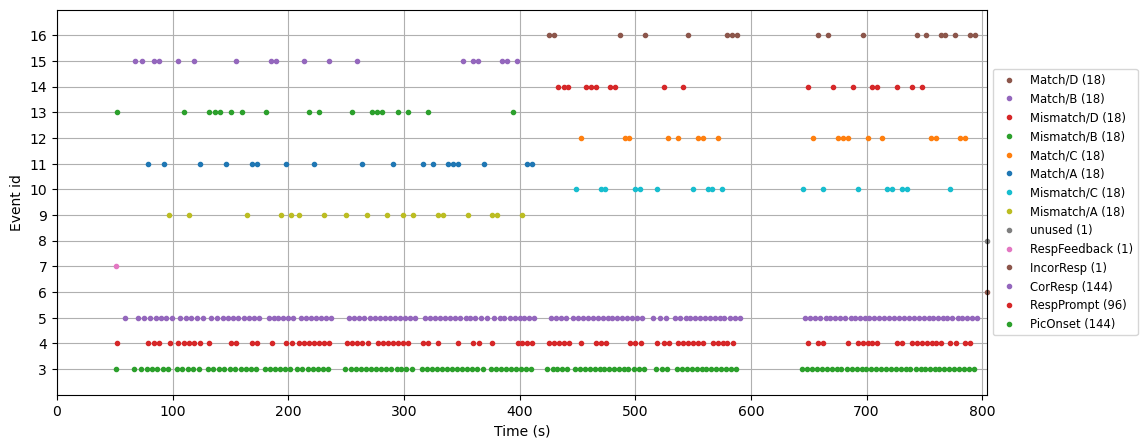

In [9]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw_filt.info['sfreq'],  
                    event_id=event_id,                    
                    axes=ax)
plt.show()

This plot of event codes over time can be very useful in ensuring that the event codes in your experiment occurred as expected. This is especially important to check when you're first pilot-testing an experiment, before you collect data from lots of participants. It's also useful simply to visualize and understand the structure of an experiment. 

For example, in the plot above the bottom three rows show lots of dots (event codes) quite regularly over the duration of the data collection. The legend tells us these correspond to picture onsets, response prompts, and correct responses. This makes sense since pictures appeared on every trial, and the participant was prompted for a response on every trial. And, participants performed the task reasonably well, so the majority of responses were correct; we can see a few incorrect responses along the line marked `4` on the *y* axis. The other event codes occur less frequently, and at somewhat random intervals – these are the individual match and mismatch trials, whose order was randomized in the experiment. However, if you look closely you can see that the experiment was broken into two blocks: the `A` and `B` trial types occurred in the first half of the experiment, while the `C` and `D` trial types occurred in the second half.

## Segment the data into epochs

Having extracted our event codes, and mapped them to labels, we are now ready to split the continuous, filtered raw EEG data into epochs time-locked to the event codes of interest, as defined in the `event_mapping` dictionary we created above. To do this we use `mne.Epochs()`, which creates an object of the class `Epochs`. The [API](https://mne.tools/stable/generated/mne.Epochs.html) for this function is: 

    mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.5, baseline=(None, 0), picks=None, preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, reject_tmax=None, detrend=None, on_missing='raise', reject_by_annotation=True, metadata=None, event_repeated='error', verbose=None)


We don't need to specify all of the arguments listed in the API, but a number of them are necessary; the first 5 of these are *positional* arguments, meaning that the first 5 arguments positions are required, must occur in the order shown, and must have specific contents:
- the first is the raw data. We will pass the filtered raw data.
- the next two arguments are the events array, and the mapping of events to labels (we'll use `event_mapping`)
- the fourth and fifth arguments are the start and end times of each epoch (`timn` and `tmax`), relative to the event code. Typically the minimum (start) time is a negative number, because for reasons explained below we want a *baseline* period to compare to the activity after the event code (typically 50-200 ms, but sometimes longer). The end time depends on the timing of the ERP components you expect to occur. Some types of stimuli and experiments (such as studies of attention, or face processing) may only be interested in ERPs that occur within, say, the first 500 ms after stimulus presentation. In language studies, interesting effects often occur up to 1 s or even longer after a word is presented. An important thing to note is that  times in MNE are always specified in *seconds* (which is a bit counter-intuitive because we commonly talk about the timing of ERPs in milliseconds).

After these 5 required positional arguments, there are many kwargs we can specify. For our purposes, the defaults for most of these are fine. However, we will specify two additional kwargs: 

The `baseline` kwarg specifies what time period to use as the baseline for each epoch. The baseline is the period before the stimulus onset, and it is used to define "zero" voltage for each trial. This is necessary because the measured electrical potentials can drift quite a lot over the course of the experiment (even after we filter out the lowest-frequency drift), and artifacts can affect absolute microVolt values as well. So the absolute microVolt values for any given epoch might be rather different from other epochs, due to drift. By subtracting the mean amplitude over the baseline period from each trial (and for each channel), we "center" the measurements for that trial such that the potentials after the onset of each event code reflect the deviations of our measurements from the baseline period. Put another way, the measurements of each epoch reflect any changes in electrical potential that occur after the event code, relative to the baseline period before it. We use `(None, 0)` for the baseline to specify the time period from the start of the epoch to the time of the event code.

:::{note}
Subtracting the baseline like this is not always necessary, or desirable. Another approach is to leave the baseline untouched at the epoching stage, and worry about it later. In particular, there is an approach called <em>baseline regression</em> (<a href="https://onlinelibrary.wiley.com/doi/10.1111/psyp.13451">Alday, 2019</a>) in which the mean amplitude of the baseline on each trial is used as a predictor in a regression model, which allows one to "regress out" the baseline on a trial-by-trial basis rather than subtracting it. This can be particularly useful in certain cases, such as when the baseline period isn't actually "silent" but contains some activity of interest (e.g., a previous word when reading a sentence or listening to a story; see e.g., <a href="https://dx.doi.org/10.3389/fpsyg.2022.668276">Sayehli et al., 2022</a>). However, the standard baseline subtraction approach is valid in most cases and we will use it here.

To make these important parameter choices easy to find and modify in our code, we will assign each value to a variable name, and in `mne.Epochs` we'll use those variables.

We also include the `preload=True` kwarg. As with `raw` data, MNE tries to save memory by not keeping the epoched data in memory unless it is needed. However, below we will need it and so we force MNE to store this in the data here. 


In [10]:
# Epoching settings
tmin =  -.100  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 

## Viewing and Indexing Epochs
If we ask for the value of `epochs` we get nice, tidy output with a summary of the contents of the data structure. 

In [11]:
epochs

Number of events,531
Events,CorResp: 144IncorResp: 1Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18PicOnset: 144RespFeedback: 1RespPrompt: 96unused: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


Epochs can be accessed in a variety of ways, all using square brackets `epochs[]`. 

If we use an integer, we get the epoch at that index position (epochs are numbered from zero to the total number of epochs, in the order that the event codes occurred in the raw data):

In [12]:
epochs[0]

Number of events,1
Events,RespFeedback: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


In [13]:
epochs[10:15]

Number of events,5
Events,CorResp: 2Match/A: 1PicOnset: 1RespPrompt: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


Alternatively, we can access all of the epochs associated with a particular event code, using the label we assigned to the code using `event_mapping`:

In [14]:
epochs['Match/A']

Number of events,18
Events,Match/A: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


These two methods can be combined to select a specific event out of those in a condition:

In [15]:
epochs['Match/A'][8]

Number of events,1
Events,Match/A: 1
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


If we pass multiple condition labels, then we will get all epochs in each of the conditions specified:

In [16]:
epochs['Match/A', 'Match/B']

Number of events,36
Events,Match/A: 18Match/B: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


MNE also recognizes the `/` separator for condition labels (e.g., in `'Match/A'`): the string before the `/` is treated as a more general category, with the string after the `/` treated as subsets of that category. So we can see all of the Match trials (`A`, `B`, `C`, & `D`) by passing `'Match'` as the condition label:

In [17]:
epochs['Match']

Number of events,72
Events,Match/A: 18Match/B: 18Match/C: 18Match/D: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


Likewise, we can see all of the epochs in the `A` condition (`Match` & `Mismatch`) by passing `'A'` as the condition label:

In [18]:
epochs['A']

Number of events,36
Events,Match/A: 18Mismatch/A: 18
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


## Visualize Average ERP Across Conditions of Interest – Before Artifact Correction

While it's useful to see the summary of the epochs object, it's more interesting to visualize the data. The `Epochs` class has a `.plot()` method to do this. Since `Epochs` contains each individual trial, if we try to plot multiple epochs (e.g., `epochs.plot()`) we will get an interactive plot (like we saw previously for scrolling through the raw data). Typically what we want to see is the *average* across all trials of a condition. This is central to ERPs — the data on each individual trial is noisy, but when we average across many trials, the noise tends to cancel out, leaving the ERP component of interest. So we need to chain the `.average()` method with `.plot()`. Here we'll average across Match and Mismatch epochs; even though ultimately we want to compare these two, for the purposes of assessing data quality we'll average them together:

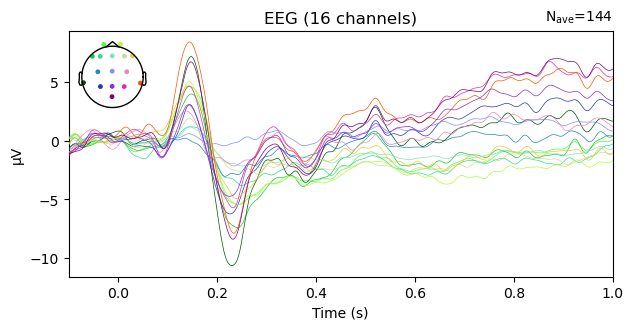

In [19]:
epochs['Match', 'Mismatch'].average().plot(); # remember the semicolon prevents a duplicated plot

The above *butterfly plot* shows all electrodes on a single axis. The color of the lines indicates where ont he head the channel was located, as shown in the inset head plot. 

<body textcolor="red">
<em>No longer true:</em>
The above plot shows strong evidence of ocular artifacts in the data: the amplitude scale is on the order of 100 µV, whereas real EEG is rarely more than 10–20 µV, and the largest amplitude values are in channels around the eyes (you can tell this by matching the colors of the lines in the plot with those of the channel locations on the inset showing the electrode layout). Remember that we created these epochs from the filtered raw data, from which we have not yet removed artifacts. 
</body>

:::{admonition} Butterflies and Rainbows

Plotting all electrodes on one axis is called a **butterfly plot**. The name may seem strange but when you use it to plot data from lots of sensors (especially MEG data), it does look somewhat like a butterfly:

![butterfly plot of MEG data containing 245 channels](https://mne.tools/dev/_images/sphx_glr_90_phantom_4DBTi_001.png). 

## Apply ICA correction to epochs

Recall that in the previous lesson, we created `epochs_ica`, with 1 s segments of the entire raw file, which we fit ICA on to identify artifacts. We then saved the indices of the ICs to `ica.exclude`, and saved the ICA decomposition to a file. Here, we can load that file and apply the ICA decomposition – and the exclusion of ICs – to the `epochs` data that we just created in the present lesson — i.e., the ERP data time-locked to events of interest. This works because what is stored in the `ica` object is not the original data that ICA was applied to, but a formula for applying a mathematical transformation to data. So we can apply that same transformation to any data that has the same number of channels as the original data.

As with many MNE methods (such as filtering, as we saw earlier), the `ICA` `.apply()` method operates on data in-place, meaning it alters the data that is passed to it. In general, it's good practice to make copies of data when applying transformations (this is especially useful when developing your own code, in case what you try doesn't work the first time. It's nice not to have to redo preivous steps to re-create your Epochs). So here we use the `.copy()` method:

In [20]:
# read the previously-saved ICA decomposition
ica = mne.preprocessing.read_ica(data_dir + p_id + '-ica.fif')

# apply the ICA decomposition (excluding the marked ICs) to the epochs
epochs_postica = ica.apply(epochs.copy())

### Visualize Average ERP After ICA Artifact Removal

We create the same butterfly plot that we did above, prior to artifact removal, so that we can see if and how the data were cleaned up. Compared to the previous plot, we can see that artifacts have been successfully removed, and the data look more like typical ERP data:
- the large-amplitude deflections seen above, largest at frontal channels, are no longer present
- the amplitude scale (*y* axis) is in the range typical of ERPs
- a series of early peaks typical of sensory ERPs are present

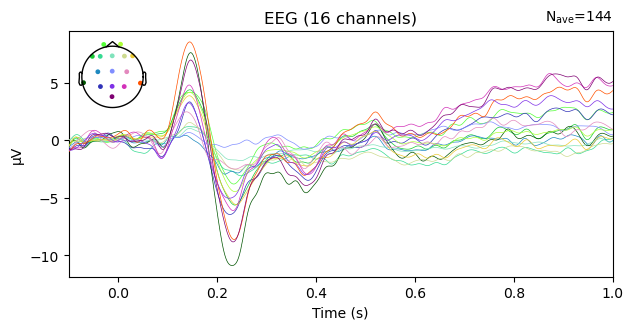

In [21]:
epochs_postica['Match', 'Mismatch'].average().plot(spatial_colors=True);

## AutoReject for Final Data Cleaning

ICA correction removed the ocular (blink and eye movement) artifacts. However, there are potentially other sources of noise remaining in the data, including muscle noise, "paroxysmal" artifacts (sudden, large-amplitude deflections), and other sources. Sometimes as well, individual channels contain noise either over the entire recording, or in specific segments. We can use the AutoReject algorithm to automatically detect and remove bad epochs and channels. Any channels that are removed are then replaced using interpolation – essentially averaging the data from surrounding channels to estimate the data from the noisy channel.

You may recall that we used AutoReject earlier, prior to running ICA. At that point, we used AutoReject to identify and exclude any particularly noisy segments of data from the ICA decomposition. But we didn't actually remove those segments from teh data set, we just told ICA to ignore them. Here, we will use AutoReject to identify *and* exclude any particularly noisy epochs, and correct noisy channels through interpolation.

Here we run the same code we used prior to ICA, except that we fit it to the `epochs_clean` data that has been cleaned with ICA. Another difference is that previously, we used the `.fit()` method to fit the AutoReject algorithm to the data, and then used the information stored in the fit to exclude noisy epochs from ICA. Here instead, we apply the `fit_transform()` method, which both fits the model, and *applies* the "transformation" (i.e., the exclusion of bad epochs and interpolation of bad channels) to the data. We include a kwarg asking the method to output a log of the steps that AutoReject took to clean the data. We can use this log to see what AutoReject did. We assign the output of this method to two variables, `epochs_clean` and `reject_log_clean`. The first is the cleaned data, and the second is the log.

:::{attention}

Remember that AutoReject can take a long time to run. Just be patient and let it run. You'll know when it's done because you'll see a description of the cleaned epochs printed below.

In [22]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_postica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(epochs_postica, return_log=True)

epochs_clean

Number of events,490
Events,CorResp: 130IncorResp: 0Match/A: 18Match/B: 18Match/C: 17Match/D: 16Mismatch/A: 18Mismatch/B: 17Mismatch/C: 15Mismatch/D: 18PicOnset: 133RespFeedback: 1RespPrompt: 89unused: 0
Time range,-0.100 – 1.000 s
Baseline,-0.100 – 0.000 s


### View AutoReject's Effects

We can plot the rejection log to see which epochs were rejected, and which channels were interpolated:

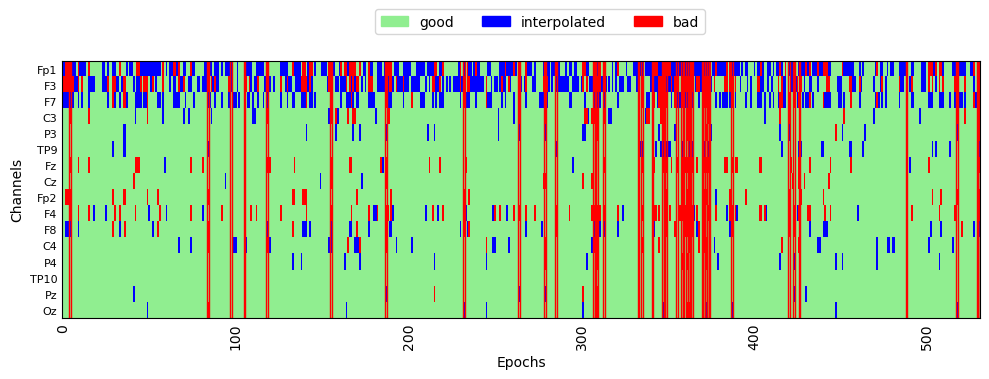

In [23]:
fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax)
plt.show()

### Visualize Average ERP After AutoReject

Let's again plot the average ERPs across all Match and Mismatch trials, after AutoReject has been applied. We'll create a figure with two subplots so we can compare the average before and after data cleaning with ICA + AutoReject:

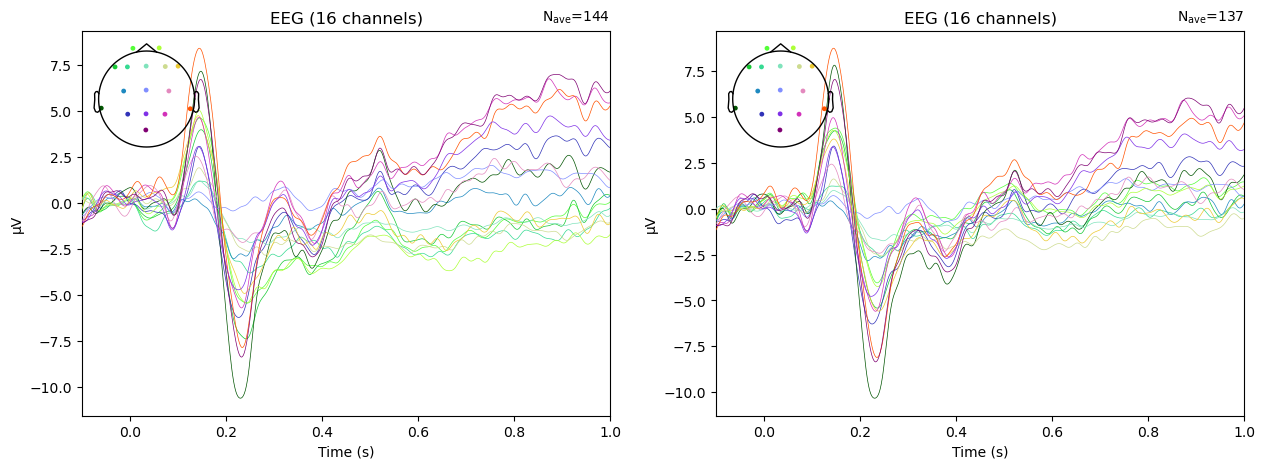

In [24]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5])

epochs['Match', 'Mismatch'].average().plot(axes=ax[0], show=False); # remember the semicolon prevents a duplicated plot
epochs_clean['Match', 'Mismatch'].average().plot(axes=ax[1]);

The data look very similar in the two panels, but there are some differences. In particular, the variability in amplitude across channels is larger prior to artifact removal. Notably, the anterior channels (shown in green/yellow hues) seem to cluster together, and are different in amplitude from other channels. This suggests that there were some ocular artifacts in the later portion of some of the epochs — since ocular artifacts are much larger over anterior than posterior channels. After cleaning, the differences between channels are decreased, providing evidence that the cleaning process had an effect. 

It's also insightful to note here that, in the average across nearly 150 epochs, the ocular artifacts do not look like a "canonical" blink or horizontal eye movement artifact, like the examples shown in the previous lesson. Since ocular artifacts typically don't occur at the same time relative to stimulus onset, and occur on a (hopefully) small number of trials, in the average their influence is more subtle. However, they can still have a large effect on the data, as we can see here.

### Scalp topography maps

As we did with ICA components, we can plot the EEG potentials over the scalp, using the `.plot_topomap()` method. The code below generates a scalp map every 100 ms, which reflects the electrical potentials averaged over a 50 ms window centered on each time point. The time range over which each plot is averaged are shown in the labels above each scalp plot; the numbers are not precisely 50 ms ranges, because the sampling rate was 500 Hz, meaning that samples were acquired every 2 ms. So we have data at, e.g., .024 and .026 s, but not at .025.

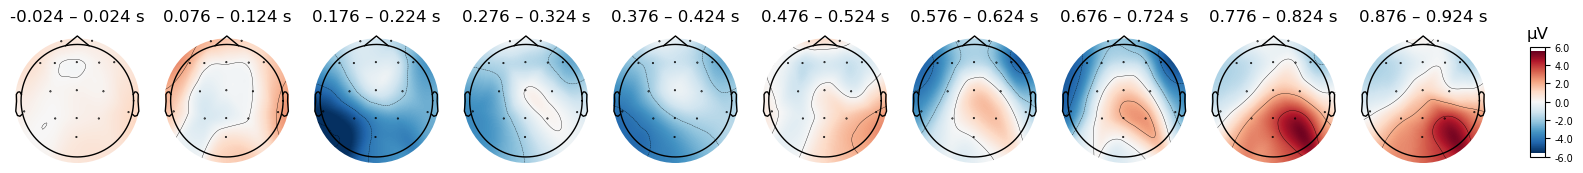

In [25]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs_clean['Match'].average().plot_topomap(times=times, average=0.050);

We can plot the Mismatch trials separately from the Match trials, to see if there are any differences in the scalp topography of the ERPs between the two conditions:

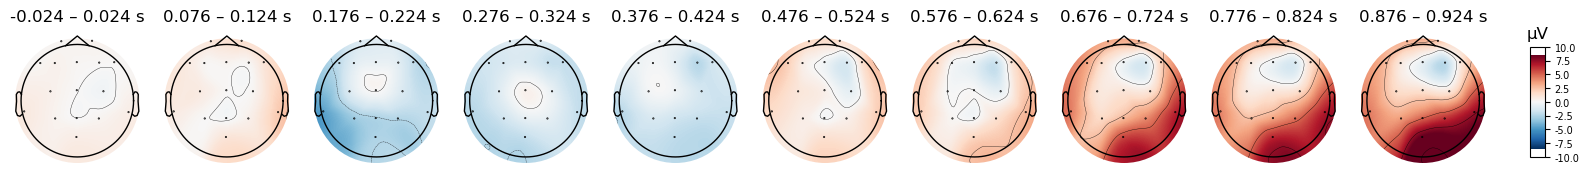

In [26]:
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050);

There do seem to be differences, but be careful: look at the range of microVolt values in the colorbars for each plot. They are different. By default, MNE scales the range of the colorbar in topo plots to the range of values in each data object that is passed to it. This is useful bin visualizing the scalp distribution of effects in any particular condition, but it makes it impossible to compare between conditions. But to compare between two plots, we need to ensure that the colorbar ranges are the same for both. We can use the `vlim` kwarg to specify the range of values to use for the *y* axis and colorbar. Here we use the same range for both conditions, so that we can compare them. Since one plot's range is ±10 µV, and the other is ±6 µV, we use ±8 as a compromise

:::{caution}

Always use a symmetrical pair of values for the `vlim` argument to `plot_topomap()` (e.g., `(-10, 10)`, but not `(-10, 5)`). The red-blue color scale that is used assumes that the values are symmetrical, so that values close to zero appear white, positive values are read, and negative values are blue. This is quite intuitive for most viewers to interpret. However, if you use an asymmetric range, then white will not be centered on zero, and the color scale will be misleading.

Match


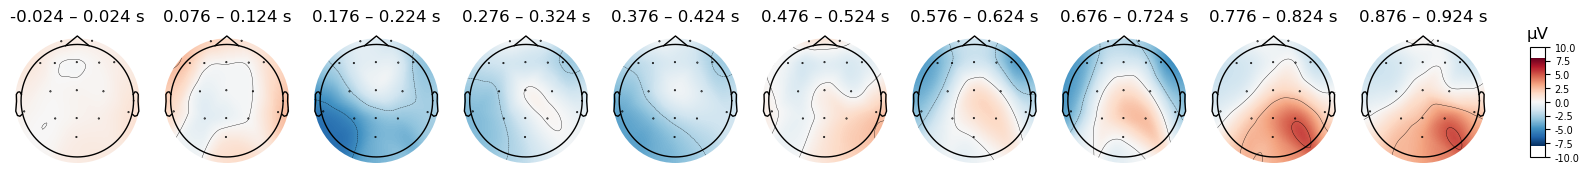

Mismatch


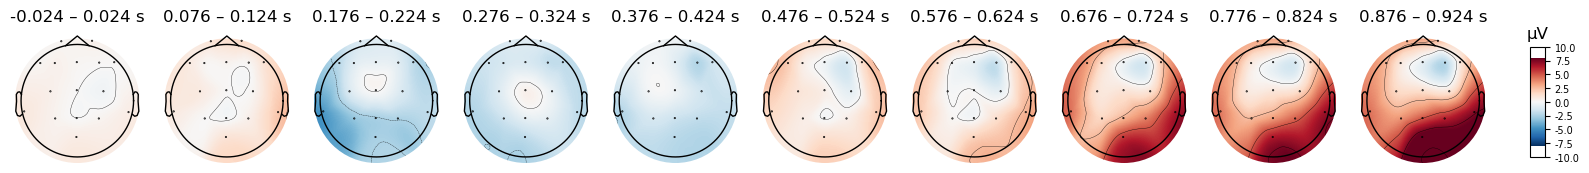

In [29]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

print('Match')
epochs_clean['Match'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

print('Mismatch')
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

The differences between conditions appear smaller now, however some differences are still visible. In the next lesson we'll explore how to visualize differences between conditions in more detail.

## Save epochs

Finally, we'll save our cleaned epochs for use in later lessons. MNE requires the `-epo` suffix for .fif files storing epochs.

In [28]:
epochs_clean.save(data_dir + p_id + '-epo.fif', overwrite=True)